In [ ]:
!pip install scikit-learn==0.24.2
!pip install statsmodels==0.12.1
!pip install shap
!pip install catboost
!pip install mlxtend

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import glob
from datetime import datetime, timedelta
import itertools
import re
import logging
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import shap
# Hyperparameter tuning
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
'''
https://www.kaggle.com/den3b81/elasticnet-lb-0-547-and-feature-importance
https://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection
https://machinelearningmastery.com/feature-selection-subspace-ensemble-in-python/
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest
'''

'\nhttps://www.kaggle.com/den3b81/elasticnet-lb-0-547-and-feature-importance\nhttps://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection\nhttps://machinelearningmastery.com/feature-selection-subspace-ensemble-in-python/\nhttps://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest\n'

Elastic Nets are essentially a Lasso/Ridge hybrid, that entails the minimization of an objective function that includes both L1 (Lasso) and L2 (Ridge) norms. You can find more about ElasticNets here.

For the sake of this notebook it is important to notice that Elastic nets depends on two parameters:

the l1_ratio, i.e. the tradeoff between the two norms (l1_ratio = 0 --> Ridge, l1_ratio = 1 --> Lasso, 0<l1_ration<1 --> Mix of the two);
alpha, that regulates the amount of penalty applied.
It is important to know that minimizing the L1 norm will force some coefficients to shrink to zero, and that's why Elastic Nets can be used as feature selection techniques. Besides, when there's a high degree of collinearity in the data, the cross-validation procedure used to determine these two parameters will return low l1_ratio since Ridge tends to outperform Lasso in these cases.

# New Section

In [ ]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it
    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum

    # return a float
    return ft_wmape_forecast


In [ ]:
def ads(iri_df,year_week_df,calendar_df,weather_df,inflation_df):
    #####processing shipment data#####
    #Creating flag for FS categories
#     FSFlag = True if (221 in shipment_df['Item.[L6]'].unique()) or (228 in shipment_df['Item.[L6]'].unique()) else False
#     print(FSFlag)
    # Renaming cols
    iri_df.rename(columns={'Version.[Version Name]':'Version Name',
                          'Time.[Week]':'WEEK_NUM',
                          'Sales Domain.[Customer Group]':'Planning_Entity',
                          'Item.[Planning Item]':'BASECODE',
                          'Consumption IRI':'Consumption'},inplace=True)


    # Converting the WEEK format to int form to do slicing and sorting
    iri_df['WEEK_NUM'] = iri_df['WEEK_NUM'].str.replace('-W','')

    # Column "Shipment_Volume" consists of values (0,+ve values)
    iri_df.loc[iri_df['Consumption'] < 0, 'Consumption'] = 0
    iri_df.loc[iri_df.Consumption.isnull(), 'Consumption']= iri_df.loc[iri_df.Consumption.isnull(), 'Consumption']
    #logger.debug(shipment_df.shape)
    #saving cat code

    # Unique combination of BASECODE, Plant , Planning_Entity, WEEK_NUM of Shipment Data
    iri_df = iri_df.groupby(['BASECODE','Planning_Entity','WEEK_NUM'])['Consumption'].sum().reset_index()

    #converting shipment week_num to int
    iri_df['WEEK_NUM'] = iri_df['WEEK_NUM'].astype(np.int64)

    #creating ship max week to filter out the shipment
    iri_max_week = iri_df['WEEK_NUM']
    iri_max_week = iri_max_week.max()

    #filtering out current week shipment
#     iri_df = iri_df[iri_df['WEEK_NUM']<iri_max_week]
    
    print("iri_df shape")
    print(iri_df.shape)

    #creating new ship max week after filtering
#     ship_max_week1 = shipment_df['WEEK_NUM']
#     ship_max_week1 = ship_max_week1.max()
#     print(ship_max_week1)

    #creating ship min week to filter out 
    iri_min_week = iri_df['WEEK_NUM']
    iri_min_week = iri_min_week.min()
    print(iri_min_week)

    
    ####Creating time-series for all shipment combination####
    ### calculate the start and current week
    curr_date = (datetime.today() - timedelta(weeks=156))
    year, week_num, day_of = curr_date.isocalendar()
    starting_week = int(str(year)+str(week_num))
    
    curr_date = (datetime.today() - timedelta(weeks=56))
    year, week_num, day_of = curr_date.isocalendar()
    filter_week = int(str(year)+str(week_num))

    year_week_df.rename(columns={'Time.[Week]':'WEEK_NUM'},inplace=True)
    year_week_df['WEEK_NUM'] = year_week_df['WEEK_NUM'].astype(str)
    year_week_df['WEEK_NUM'] = year_week_df['WEEK_NUM'].str.replace('-W','')
    year_week_df['WEEK_NUM'] = year_week_df['WEEK_NUM'].astype(np.int64)
    year_week_df = year_week_df[(year_week_df['WEEK_NUM']>=iri_min_week)&(year_week_df['WEEK_NUM']<=202152)]
    try:
        year_week_df.drop(['Time.[WeekKey]'],axis=1,inplace=True)
    except:
        pass
    # Creating all combination of basecode planning entity plant salesorg
    
    map_df = iri_df[iri_df['WEEK_NUM']>filter_week][['BASECODE','Planning_Entity']].drop_duplicates()


    # Unique BASECODE,Plant,Planning_Entity combination ( mapping the two tables year_week_df, map_df with a key , as it is no common column )
    map_df['key'] = 1
    year_week_df['key'] = 1
    map_df = pd.merge(year_week_df,map_df,on='key')
    map_df.drop(columns='key',inplace=True)

    ### Mapping time-series shipment combination with shipment data
    iri_df['WEEK_NUM'] = iri_df['WEEK_NUM'].astype(np.int64)
    main_df=pd.merge(map_df, iri_df, on=['WEEK_NUM','BASECODE','Planning_Entity'],how='left').drop_duplicates()


    ## Filtering nulls weeks before starting the shipment
    main_df = main_df.groupby(['BASECODE','Planning_Entity'], as_index=False).apply(lambda x: \
                        x[x['WEEK_NUM']>=(x[x['Consumption']>=0]['WEEK_NUM'].min())]).reset_index()

    main_df = main_df[['WEEK_NUM','BASECODE','Planning_Entity','Consumption']]


    ### Adding Macro-economic drivers

    # Extraction of Holiday Calendar

    calendar_df = calendar_df[calendar_df['Sales Domain.[Country]']=='US']
    calendar_df.rename(columns={'Time.[Week]':'WEEK_NUM'},inplace=True)

    calendar_df['WEEK_NUM'] = calendar_df['WEEK_NUM'].str.replace('-W','')
    calendar_df = calendar_df.pivot_table(index=['WEEK_NUM'],columns='Holiday Type',values='Is Holiday',aggfunc='mean',fill_value=0).reset_index()
    calendar_df = calendar_df.rename_axis(None, axis=1) 

    for i in calendar_df.columns:
        if 'WEEK' not in i:
            calendar_df.rename(columns={i:'holiday_'+i}, inplace=True)
    print("Holiday shape")
    print(calendar_df.shape)
    calendar_df['WEEK_NUM'] = calendar_df['WEEK_NUM'].astype(np.int64)
    main_df= pd.merge(main_df,calendar_df, on ='WEEK_NUM', how='left').drop_duplicates()

    # Creating lead1 and lead2 features for Holiday
    holiday_col = [col for col in main_df if col.startswith('holiday')]

    for col in holiday_col:
        main_df[col+'_lead1'] = main_df.groupby(['BASECODE','Planning_Entity'])[col].shift(-2)
        main_df[col+'_lead2'] = main_df.groupby(['BASECODE','Planning_Entity'])[col].shift(-3)


    weather_df = weather_df[weather_df['Sales Domain.[Country]']=='US']
    weather_df.rename(columns={'Time.[Week]':'WEEK_NUM'},inplace=True)
    weather_df['WEEK_NUM'] = weather_df['WEEK_NUM'].str.replace('-W','')
    weather_df = weather_df[['WEEK_NUM','Precipitation','Temperature']]
    print("weather shape")
    print(weather_df.shape)

    weather_df['WEEK_NUM'] = weather_df['WEEK_NUM'].astype(np.int64)

    # Merging weather_data with final data
    #main_df = pd.merge(main_df, weather_df, on='WEEK_NUM', how='left').drop_duplicates()

    #### Inflation
    # Inflation data
    inflation_df = inflation_df[inflation_df['Sales Domain.[Country]']=='US']
    inflation_df.rename(columns={'Time.[Week]':'WEEK_NUM'},inplace=True)
    inflation_df['WEEK_NUM'] = inflation_df['WEEK_NUM'].str.replace('-W','')
    inflation_df = inflation_df[['WEEK_NUM','CPI','PPI']]
    print("Inflation shape")
    print(inflation_df.shape)

    # Merging inflation data with final data
    inflation_df['WEEK_NUM'] = inflation_df['WEEK_NUM'].astype(np.int64)
    main_df= pd.merge(main_df,inflation_df, on ='WEEK_NUM', how='left').drop_duplicates()

    ### Adding Covid Flag
    # week number is hardcoded as it is not going to change
    main_df['Covid_flag'] = 0
    main_df.loc[(main_df.WEEK_NUM>202005) & (main_df.WEEK_NUM<202028),'Covid_flag']=1
    

    #### Filtering shipments
   
    print("Before Splitting to ML and MLL data")
    print(main_df.shape)

    ### Creating data for ML and MLL
    #data for ML model
#     main_df = main_df[main_df['IRI_flag']==1]
#     print("shape of main_df")
#     print(main_df.shape)

    #data for MLL model
#     mll_df = main_df[main_df['IRI_flag']==0]

#     main_df = main_df[(main_df['SalesOrg']!='CA01-20')&(mll_df['SalesOrg']!='CA01-30')]
#     print("shape of mll_df")
    print(main_df.shape)
    
    main_df = main_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
#     mll_df = mll_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    return main_df,starting_week,iri_max_week,iri_min_week


In [ ]:
##Reading compass data
# temp_compass_df = pd.read_csv(r'E:\Project\KHC\Parallel_Run_week7\Compass\Compass_025_17June.csv')
# temp_planitem_df = pd.read_csv(r'E:\Project\KHC\Parallel_Run_week7\Compass\Compass_Mapping_17June.csv')

##Reading Mapping files and Macro-economic files
year_week_df = pd.read_csv(r"TimeMap.csv")
calendar_df = pd.read_csv(r'Holiday_map.csv')
weather_df = pd.read_csv(r"Fact.WeatherDataTenant.csv")
inflation_df = pd.read_csv(r'Fact.Inflation.csv')


##CreamCheese ML result for 4 Models
print("*************3-Running Coldcuts*********************")
iri_df = pd.read_csv("IRI_Consumption_038.csv")

# vol.to_csv("Result/Fact.VolumeDecomposition_CreamCheese_025_17June_fwd_Model1.csv",index=False)
# feat.to_csv("Result/Fact.FeatureImportance_CreamCheese_025_17June_Fwd_Model1.csv",index=False)
main_df,starting_week,iri_max_week,iri_min_week = ads(iri_df=iri_df,year_week_df=year_week_df,calendar_df=calendar_df,weather_df=weather_df,inflation_df=inflation_df)

*************3-Running Coldcuts*********************
iri_df shape
(103060, 4)
201652
Holiday shape
(76, 13)
weather shape
(338, 3)
Inflation shape
(326, 3)
Before Splitting to ML and MLL data
(105164, 43)
(105164, 43)


In [ ]:
main_df.fillna(0,inplace=True)
result = seasonal_decompose(main_df["Consumption"], model='additive', period=7)
main_df['trend_overall'] = result.trend
main_df['season_overall'] = result.seasonal

#Creating LY and LYY Trend
main_df['trend_53'] = main_df.groupby(['BASECODE','Planning_Entity'])['trend_overall'].shift(53)
main_df['trend_105'] = main_df.groupby(['BASECODE','Planning_Entity'])['trend_overall'].shift(105)
main_df['seasonal_53'] = main_df.groupby(['BASECODE','Planning_Entity'])['season_overall'].shift(53)
main_df['seasonal_105'] = main_df.groupby(['BASECODE','Planning_Entity'])['season_overall'].shift(105)


# Filling 2018 Trend_105 value with 2019 values
main_df['sample'] = main_df.groupby(['BASECODE','Planning_Entity'])['trend_105'].shift(-52)
main_df.loc[(main_df.WEEK_NUM>=iri_min_week)&(main_df.WEEK_NUM<=201852),'trend_105'] = main_df.loc[(main_df.WEEK_NUM>=iri_min_week)&(main_df.WEEK_NUM<=201852),'sample']
main_df['sample_1'] = main_df.groupby(['BASECODE','Planning_Entity'])['seasonal_105'].shift(-52)
main_df.loc[(main_df.WEEK_NUM>=iri_min_week)&(main_df.WEEK_NUM<=201852),'seasonal_105'] = main_df.loc[(main_df.WEEK_NUM>=iri_min_week)&(main_df.WEEK_NUM<=201852),'sample_1']
main_df.drop(columns=['sample','sample_1'],inplace=True)

remove = ['Consumption','BASECODE',
'WEEK_NUM','Planning_Entity','SalesOrg','IRI_flag','PRICE_REDUCTIONS_ONLY_PROMO_FLAG','DISPLAY_ONLY_PROMO_FLAG',
'FEATURE_DISPLAY_PROMO_FLAG','FEATURE_ONLY_PROMO_FLAG','season_overall','trend_overall']

# weeks to use for lag2 backtesting
backtest_length  = 13
backtest_lag = 2
current_week = list(range(iri_max_week - backtest_length - backtest_lag, iri_max_week - backtest_lag))
print(current_week)
print(len(current_week))
print(iri_max_week)

for k in current_week:
    weeklist = sorted(i for i in main_df['WEEK_NUM'].unique().tolist() if (i > k)& (i <= iri_max_week))
    print(weeklist)

    main_df['WEEK_NUM'] = main_df['WEEK_NUM'].astype(np.int64)
    train = main_df[(main_df['WEEK_NUM']>starting_week)&(main_df['WEEK_NUM']<=k)]
    test = main_df[(main_df['WEEK_NUM']>k)]

    print("train and test")
    print(train.shape)
    print(test.shape)

    #     ls = train['Plant'].unique().tolist()
    #     test = test[test['Plant'].isin(ls)]

    ls1 = train['Planning_Entity'].unique().tolist()
    test = test[test['Planning_Entity'].isin(ls1)]

    ls2 = train['BASECODE'].unique().tolist()
    test = test[test['BASECODE'].isin(ls2)]

    dummy1 = pd.get_dummies(train['BASECODE'])
    dummy2 = pd.get_dummies(train['Planning_Entity'])
    train = pd.concat([train,dummy1,dummy2], axis=1)

    train.replace(np.inf, np.nan, inplace=True)
    train.fillna(0,inplace=True)

    dummy1 = pd.get_dummies(test['BASECODE'])
    dummy2 = pd.get_dummies(test['Planning_Entity'])
    test = pd.concat([test,dummy1,dummy2], axis=1)

    test.replace(np.inf, np.nan, inplace=True)
    test.fillna(0,inplace=True)

    cols = test.columns.to_list()
    train = train[cols]

    train_y1 = train['Consumption']
    train_x1 = train[train.columns[~train.columns.isin(remove)]]

    #################################################################################
    # Investigating if there are constant or semi-constat feature in X_train
    from sklearn.feature_selection import VarianceThreshold
    # Removing all features that have variance under 0
    selector0 = VarianceThreshold(threshold = 0)
    selector0.fit(train_x1)
    mask_clean0 = selector0.get_support()
    train_x1_clean = train_x1[train_x1.columns[mask_clean0]]
    print(train_x1.shape, train_x1_clean.shape)
    print("****")
    print(train_x1.columns)
    print("****")
    print(train_x1_clean.columns)
    print("****")

    selector01 = VarianceThreshold(threshold = 0.01)
    selector01.fit(train_x1)
    mask_clean01 = selector01.get_support()
    train_x1_clean = train_x1_clean[train_x1_clean.columns[mask_clean01]]
    print(train_x1.shape, train_x1_clean.shape)
    print("****")
    print(train_x1.columns)
    print("****")
    print(train_x1_clean.columns)
    print("****")
    print("$$$$$$$$$")


[202116, 202117, 202118, 202119, 202120, 202121, 202122, 202123, 202124, 202125, 202126, 202127, 202128]
13
202131
[202117, 202118, 202119, 202120, 202121, 202122, 202123, 202124, 202125, 202126, 202127, 202128, 202129, 202130, 202131]
train and test
(56239, 49)
(15922, 49)
(56239, 116) (56239, 116)
****
Index([             'holiday_ChristmasDay',
                     'holiday_ColumbusDay',
                          'holiday_Easter',
       'holiday_GeorgeWashingtonsBirthday',
                 'holiday_IndependenceDay',
                        'holiday_LaborDay',
           'holiday_MartinLutherKingJrDay',
                     'holiday_MemorialDay',
                     'holiday_NewYearsDay',
                 'holiday_SuperBowlSunday',
       ...
                               'US4000159',
                               'US4000288',
                               'US4000289',
                               'US4000290',
                               'US4000856',
                       

In [ ]:
#  finding non-constant features
len(train_x1.columns[selector0.get_support()]), len(train_x1.columns[selector01.get_support()])

(118, 96)

In [ ]:
# print the constant features
print(len([x for x in train_x1.columns if x not in train_x1.columns[selector0.get_support()]]))

[x for x in train_x1.columns if x not in train_x1.columns[selector0.get_support()]]

0


[]

I think there will be a problem where item/pe/location is very frequent, in that case most of the values will be having 1 and will be treated as quassi-constant, need to confirm.


In [ ]:
# print the constant features
print(len([x for x in train_x1.columns if x not in train_x1.columns[selector01.get_support()]]))

[x for x in train_x1.columns if x not in train_x1.columns[selector01.get_support()]]

22


[447000003600,
 447000006400,
 447000007700,
 447000009500,
 447000009800,
 447000021100,
 447000798100,
 447000798200,
 447000873300,
 447000972500,
 447001017000,
 447001017100,
 447001017200,
 718710012400,
 718715420100,
 718715447200,
 'US3000063',
 'US3000119',
 'US4000044',
 'US4000055',
 'US4000289',
 'US4000290']

2.2 Univariate selection methods 
Table of Contents

Univariate feature selection methods works by selecting the best features based on univariate statistical tests like ANOVA. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method.

The methods based on F-test estimate the degree of linear dependency between two random variables. They assume a linear relationship between the feature and the target. These methods also assume that the variables follow a Gaussian distribution.

There are 4 methods that fall under this category :-

SelectKBest
SelectPercentile
SelectFpr, SelectFdr, or family wise error SelectFwe
GenericUnivariateSelection
Source : https://scikit-learn.org/stable/modules/feature_selection.html

In [ ]:
# select the two best features
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2
#train_x1_new1 = SelectKBest(chi2, k=2).fit_transform(train_x1, train_y1)
#train_x1_new1.shape
# now select features based on top 10 percentile
#train_x1_new2 = SelectPercentile(chi2, percentile=10).fit_transform(train_x1, train_y1)
#train_x1_new2.shape

# Compare Chi-Squared Statistics
# select two features with highest chi-squared statistics
#chi2_selector = SelectKBest(chi2, k=2)
#X_kbest = chi2_selector.fit_transform(train_x1, train_y1)

ValueError: ignored

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(train_x1, 0.8)
print('correlated features: ', len(set(corr_features)) )

ModuleNotFoundError: ignored

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNetCV, ElasticNet

cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')
cv_model.fit(train_x1, train_y1)

ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1],
             max_iter=2000, n_jobs=-1, normalize=True)

In [ ]:
model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
model.fit(train_x1, train_y1)

ElasticNet(alpha=1.7390010891334968, l1_ratio=1.0, max_iter=37, normalize=True)

7 features, reduction of 94.07%


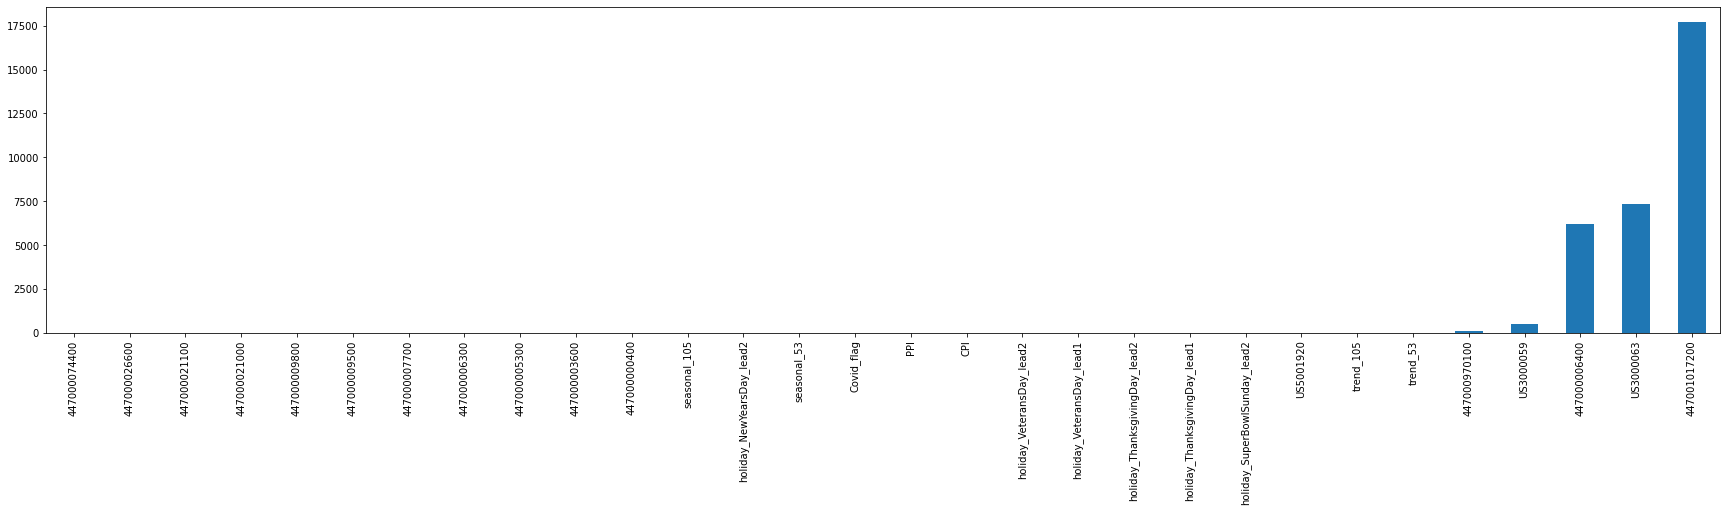

In [ ]:
feature_importance = pd.Series(index = train_x1.columns, data = np.abs(model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (30,6))

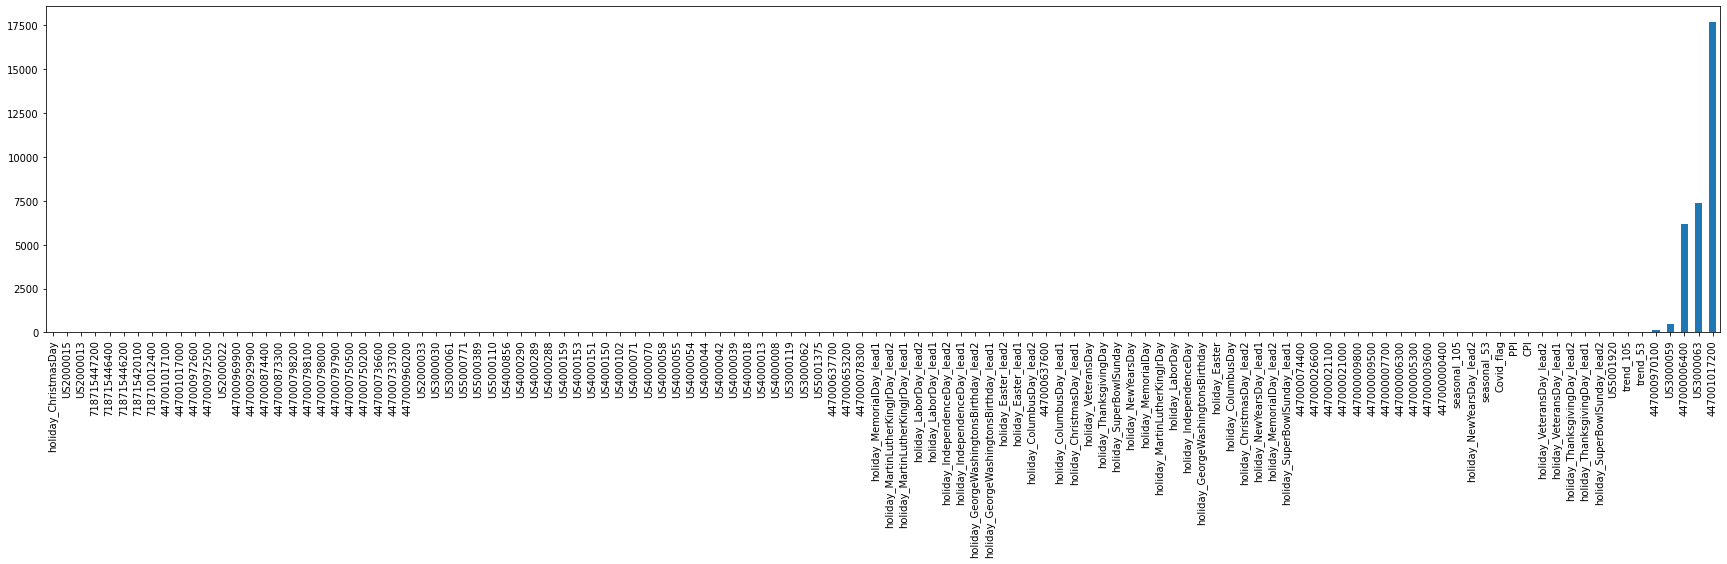

In [ ]:
feature_importance.sort_values().plot(kind = 'bar', figsize = (30,6))

In [ ]:
model.coef_

array([-0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  8.06008106e-01,
        2.35926015e-01, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.18708874e+03,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [ ]:
train_x1.columns

Index([             'holiday_ChristmasDay',
                     'holiday_ColumbusDay',
                          'holiday_Easter',
       'holiday_GeorgeWashingtonsBirthday',
                 'holiday_IndependenceDay',
                        'holiday_LaborDay',
           'holiday_MartinLutherKingJrDay',
                     'holiday_MemorialDay',
                     'holiday_NewYearsDay',
                 'holiday_SuperBowlSunday',
       ...
                               'US4000159',
                               'US4000288',
                               'US4000289',
                               'US4000290',
                               'US4000856',
                               'US5000110',
                               'US5000389',
                               'US5000771',
                               'US5001375',
                               'US5001920'],
      dtype='object', length=118)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNetCV, ElasticNet

cv_model1 = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.0001, n_alphas=1000, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=10000, tol=0.0001, cv=10, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')
cv_model1.fit(train_x1, train_y1)


ElasticNetCV(cv=10, eps=0.0001,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1],
             max_iter=10000, n_alphas=1000, n_jobs=-1, normalize=True)

In [ ]:
model1 = ElasticNet(l1_ratio=cv_model1.l1_ratio_, alpha = cv_model1.alpha_, max_iter=cv_model1.n_iter_, fit_intercept=True, normalize = True)
model1.fit(train_x1, train_y1)

ElasticNet(alpha=2.4743037147480678, l1_ratio=1.0, max_iter=37, normalize=True)

6 features, reduction of 94.92%


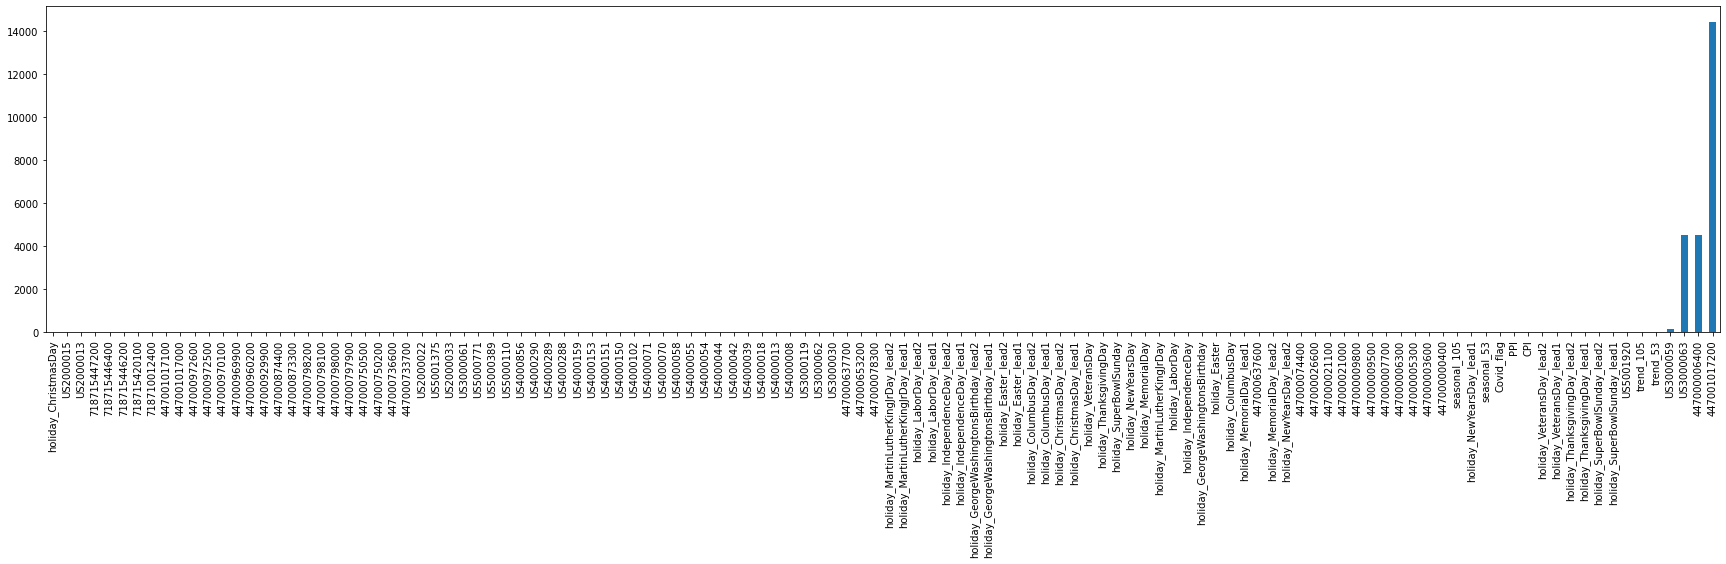

In [ ]:
feature_importance1 = pd.Series(index = train_x1.columns, data = np.abs(model1.coef_))

n_selected_features1 = (feature_importance1>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features1,(1-n_selected_features1/len(feature_importance1))*100))

feature_importance1.sort_values().plot(kind = 'bar', figsize = (30,6))

['holiday_ChristmasDay' 'holiday_ColumbusDay' 'holiday_Easter'
 'holiday_GeorgeWashingtonsBirthday' 'holiday_IndependenceDay'
 'holiday_LaborDay' 'holiday_MartinLutherKingJrDay' 'holiday_MemorialDay'
 'holiday_NewYearsDay' 'holiday_SuperBowlSunday' 'holiday_ThanksgivingDay'
 'holiday_VeteransDay' 'holiday_ChristmasDay_lead1'
 'holiday_ChristmasDay_lead2' 'holiday_ColumbusDay_lead1'
 'holiday_ColumbusDay_lead2' 'holiday_Easter_lead1' 'holiday_Easter_lead2'
 'holiday_GeorgeWashingtonsBirthday_lead1'
 'holiday_GeorgeWashingtonsBirthday_lead2' 'holiday_IndependenceDay_lead1'
 'holiday_IndependenceDay_lead2' 'holiday_LaborDay_lead1'
 'holiday_LaborDay_lead2' 'holiday_MartinLutherKingJrDay_lead1'
 'holiday_MartinLutherKingJrDay_lead2' 'holiday_MemorialDay_lead1'
 'holiday_MemorialDay_lead2' 'holiday_NewYearsDay_lead1'
 'holiday_NewYearsDay_lead2' 'holiday_SuperBowlSunday_lead1'
 'holiday_SuperBowlSunday_lead2' 'holiday_ThanksgivingDay_lead1'
 'holiday_ThanksgivingDay_lead2' 'holiday_Veterans

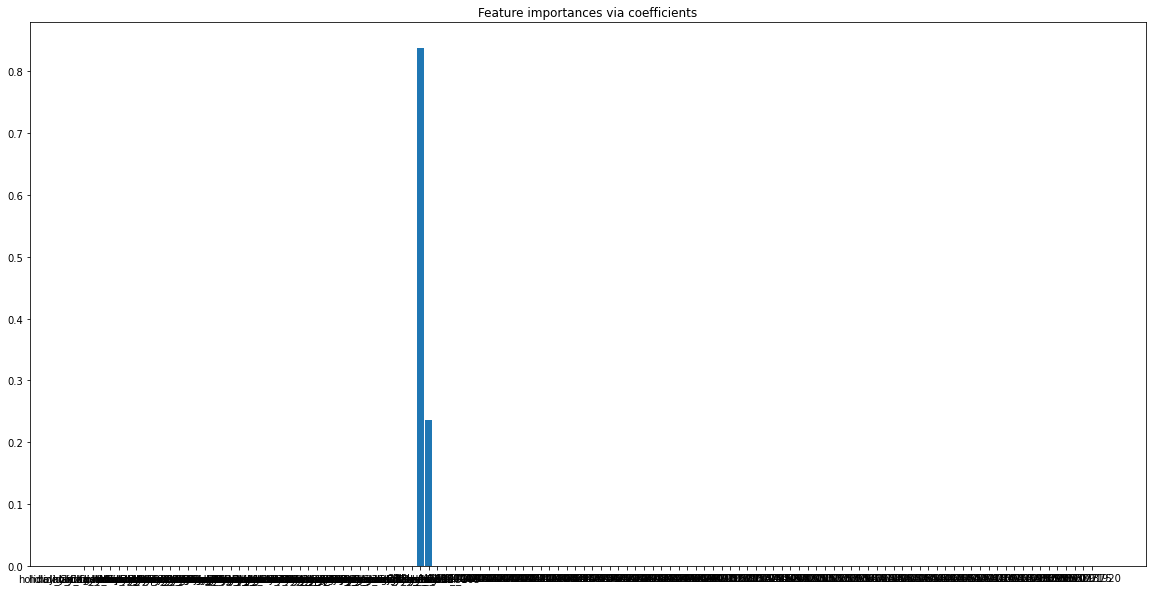

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
lasso = LassoCV().fit(train_x1, train_y1)
importance = np.abs(lasso.coef_)
feature_names = np.array(train_x1.columns)
print(feature_names)
importance_df = pd.DataFrame(importance)
importance_df = importance_df.T
importance_df.columns = list(feature_names)
figure(figsize=(20, 10))
plt.bar(height = importance, x = np.array([str(c) for c in train_x1.columns]))
plt.title("Feature importances via coefficients")
plt.show()

In [ ]:
importance

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.83743069,
       0.23659351, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
np.array(train_x1.columns)

array(['holiday_ChristmasDay', 'holiday_ColumbusDay', 'holiday_Easter',
       'holiday_GeorgeWashingtonsBirthday', 'holiday_IndependenceDay',
       'holiday_LaborDay', 'holiday_MartinLutherKingJrDay',
       'holiday_MemorialDay', 'holiday_NewYearsDay',
       'holiday_SuperBowlSunday', 'holiday_ThanksgivingDay',
       'holiday_VeteransDay', 'holiday_ChristmasDay_lead1',
       'holiday_ChristmasDay_lead2', 'holiday_ColumbusDay_lead1',
       'holiday_ColumbusDay_lead2', 'holiday_Easter_lead1',
       'holiday_Easter_lead2', 'holiday_GeorgeWashingtonsBirthday_lead1',
       'holiday_GeorgeWashingtonsBirthday_lead2',
       'holiday_IndependenceDay_lead1', 'holiday_IndependenceDay_lead2',
       'holiday_LaborDay_lead1', 'holiday_LaborDay_lead2',
       'holiday_MartinLutherKingJrDay_lead1',
       'holiday_MartinLutherKingJrDay_lead2', 'holiday_MemorialDay_lead1',
       'holiday_MemorialDay_lead2', 'holiday_NewYearsDay_lead1',
       'holiday_NewYearsDay_lead2', 'holiday_SuperBowlS